## Filter Methods - Basics - Correlations - Univariate ROC-AUC
### Putting it all together

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score #to evaluate and rank the individual features

In [2]:
# load the Santander customer satisfaction dataset from Kaggle

data = pd.read_csv('training_data/santander.csv')
data.shape

(76020, 371)

In [3]:
data.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [4]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['TARGET'], axis=1),
    data['TARGET'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((53214, 370), (22806, 370))

In [5]:
# I keep a copy of the dataset with all the variables
# to measure the performance of machine learning models
# at the end of the notebook

X_train_original = X_train.copy()
X_test_original = X_test.copy()

### Remove constant features

In [6]:
# remove constant features
constant_features = [
    feat for feat in X_train.columns if X_train[feat].std() == 0
]

X_train.drop(labels=constant_features, axis=1, inplace=True)
X_test.drop(labels=constant_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((53214, 332), (22806, 332))

### Remove quasi-constant features

In [7]:
# remove quasi-constant features
sel = VarianceThreshold(
    threshold=0.01)  # 0.1 indicates 99% of observations approximately

sel.fit(X_train)  # fit finds the features with low variance

sum(sel.get_support()) # how many not quasi-constant?

268

In [8]:
features_to_keep = X_train.columns[sel.get_support()]

In [9]:
# we can then remove the features like this
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((53214, 268), (22806, 268))

In [10]:
# sklearn transformations lead to numpy arrays
# here I transform the arrays back to dataframes
# please be mindful of getting the columns assigned
# correctly

X_train= pd.DataFrame(X_train)
X_train.columns = features_to_keep

X_test= pd.DataFrame(X_test)
X_test.columns = features_to_keep

### Remove duplicated features

In [11]:
# check for duplicated features in the training set
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)

    col_1 = X_train.columns[i]

    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260


16

In [12]:
# remove duplicated features
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test.drop(labels=duplicated_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((53214, 252), (22806, 252))

In [13]:
# I keep a copy of the dataset except constant and duplicated variables
# to measure the performance of machine learning models
# at the end of the notebook

X_train_basic_filter = X_train.copy()
X_test_basic_filter = X_test.copy()

### Remove correlated features

In [14]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.8)
print('correlated features: ', len(set(corr_features)) )

correlated features:  133


In [15]:
# removed correlated  features
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((53214, 119), (22806, 119))

In [16]:
# keep a copy of the dataset at  this stage
X_train_corr = X_train.copy()
X_test_corr = X_test.copy()

### Remove features using univariate roc_auc

This procedure works as follows:

- First, it builds one decision tree per feature, to predict the target
- Second, it makes predictions using the decision tree and the mentioned feature
- Third, it ranks the features according to the machine learning metric (roc-auc or mse)
- It selects the highest ranked features

In [17]:
# find important features using univariate roc-auc

# loop to build a tree, make predictions and get the roc-auc
# for each feature of the train set

roc_values = []  # initialize a list to store the roc-auc values for the individual features
for feature in X_train.columns:   # loop over all the features in the training set
    clf = DecisionTreeClassifier()  # initilize the decision tree
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train) # feed the tree to that single feature and the target
    y_scored = clf.predict_proba(X_test[feature].fillna(0).to_frame())  #calculate the probability of the target being 1
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))  # estimate the roc-auc between that prediction and the target and add it to our list

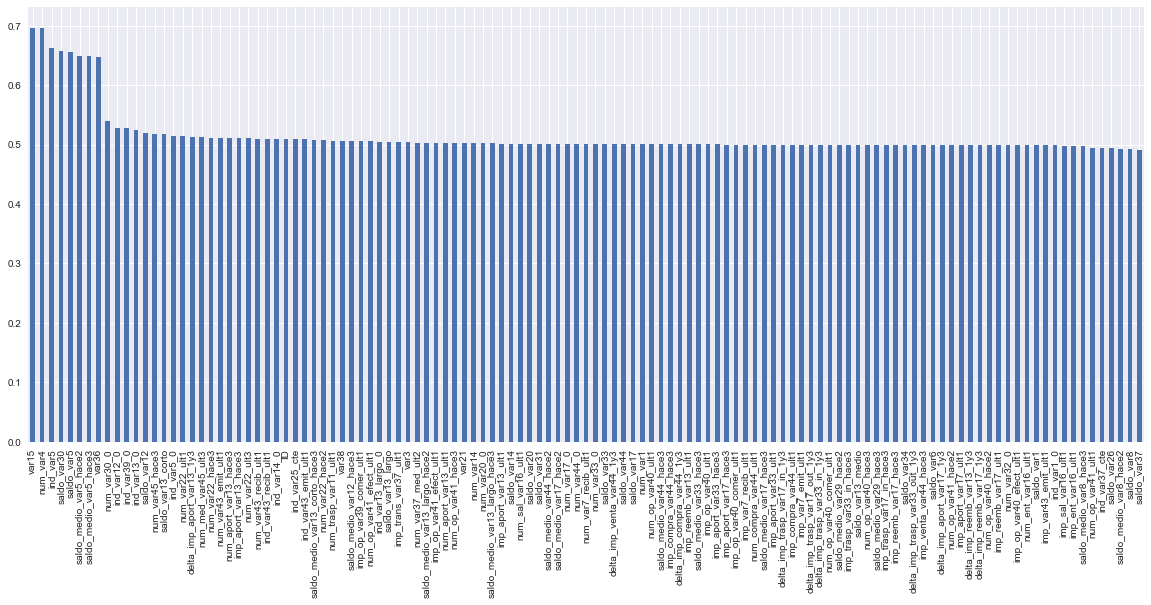

In [18]:
# let's add the variable names and order it for clearer visualisation
roc_values = pd.Series(roc_values)  # convert the list of the roc-auc scores to a Series
roc_values.index = X_train.columns  # add the columns in the index
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 8))  # order the series according to their roc-auc values and plot them

We can see that there are some features with predictive value, where the roc-auc is above 0.6, and lots of features where the roc-auc is almost or equal to 0.5 - they do not offer any predictive value. A roc-auc of 0.5 indicate random prediction, so, in principle, we can go ahead and remove them.

In [19]:
# by removing features with univariate roc_auc == 0.5
# we remove another 30 features

selected_feat = roc_values[roc_values>0.5]
len(selected_feat), X_train.shape[1]

(90, 119)

You can of course tune the parameters of the Decision Tree and get better predictions. I leave this to you. But remember that the key here is not to make ultra predictive Decision Trees, rather to use them to screen quickly for important features. So we would recommend you don't spend too much time tuning. Doing cross validation with sklearn should be very straight forward  to get a more accurate measure of the roc-auc per feature.

Once again, where we put the cut-off to select features is a bit arbitrary, other than > 0.5. It will be up to you.

### Compare the performance in machine learning algorithms

In [20]:
# create a function to build random forests and compare performance in train and test set

def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)
    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [21]:
# original
run_randomForests(X_train_original.drop(labels=['ID'], axis=1),
                  X_test_original.drop(labels=['ID'], axis=1),
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8012315676132568
Test set
Random Forests roc-auc: 0.7900499757912425


In [22]:
# filter methods - basic
run_randomForests(X_train_basic_filter.drop(labels=['ID'], axis=1),
                  X_test_basic_filter.drop(labels=['ID'], axis=1),
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8016570464386661
Test set
Random Forests roc-auc: 0.7910330692426437


In [23]:
# filter methods - correlation
run_randomForests(X_train_corr.drop(labels=['ID'], axis=1),
                  X_test_corr.drop(labels=['ID'], axis=1),
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8073914001626228
Test set
Random Forests roc-auc: 0.793766724733034


In [24]:
# filter methods - univariate roc-auc
run_randomForests(X_train[selected_feat.index],
                  X_test_corr[selected_feat.index],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8105671870819526
Test set
Random Forests roc-auc: 0.7985492537265694


We can see that removing constant, quasi-constant, duplicated, correlated and now **features with univariate roc-auc ==0.5** we still keep or even enhance the performance of the random forests (0.7985 vs 0.7900) at the time that we reduce the feature space dramatically (from 371 to 90).

And we am sure there is still more to squeeze out of this dataset, so stay tuned for the coming lectures.

Meanwhile, let's have a look at the performance of logistic regression.

In [25]:
# create a function to build logistic regression and compare performance in train and test set

def run_logistic(X_train, X_test, y_train, y_test):
    # function to train and test the performance of logistic regression
    logit = LogisticRegression(random_state=44)
    logit.fit(X_train, y_train)
    print('Train set')
    pred = logit.predict_proba(X_train)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    print('Test set')
    pred = logit.predict_proba(X_test)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [26]:
# original
scaler = StandardScaler().fit(X_train_original.drop(labels=['ID'], axis=1))

run_logistic(scaler.transform(X_train_original.drop(labels=['ID'], axis=1)),
             scaler.transform(X_test_original.drop(labels=['ID'], axis=1)),
                  y_train, y_test)

Train set
Logistic Regression roc-auc: 0.8069993931539998
Test set
Logistic Regression roc-auc: 0.7936271145679946


/Users/rcc/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [ ]:
# filter methods - basic
scaler = StandardScaler().fit(X_train_basic_filter.drop(labels=['ID'], axis=1))

run_logistic(scaler.transform(X_train_basic_filter.drop(labels=['ID'], axis=1)),
             scaler.transform(X_test_basic_filter.drop(labels=['ID'], axis=1)),
                  y_train, y_test)

In [ ]:
# filter methods - correlation
scaler = StandardScaler().fit(X_train_corr.drop(labels=['ID'], axis=1))

run_logistic(scaler.transform(X_train_corr.drop(labels=['ID'], axis=1)),
             scaler.transform(X_test_corr.drop(labels=['ID'], axis=1)),
                  y_train, y_test)

In [ ]:
# filter methods - univariate roc-auc
scaler = StandardScaler().fit(X_train[selected_feat.index])

run_logistic(scaler.transform(X_train[selected_feat.index]),
             scaler.transform(X_test_corr[selected_feat.index]),
                  y_train, y_test)

Similarly, removing constant, quasi-constant, duplicated, correlated and those with univariate roc_auc == 0.5, helped improve the performance of logistic regression (0.795 vs 0.794) at the time it reduced the feature space dramatically (371 to 90).

We have now an equally or even slightly more predictive model that is at the time simpler, as it uses less than a third of the original features.